In [22]:
#Connexión drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagen de entrada


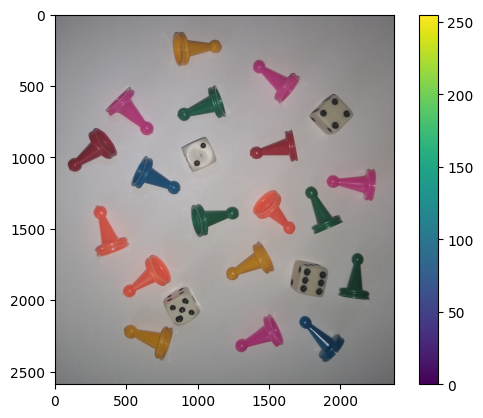

In [24]:
#Cargando la imagen
Ruta = r'/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana3/Caso_1.bmp'
Img = cv2.imread(Ruta)
print('imagen de entrada')
plt.imshow(Img[:,:,[2,1,0]].astype('uint8'),vmin=0, vmax=255)
plt.colorbar()
plt.show()

**Análisis de canales para segmentación**

In [25]:
#Extracción de canales HSV
ImgHsv = cv2.cvtColor(Img,cv2.COLOR_BGR2HSV)
Hue = ImgHsv[:,:,0]
Saturation = ImgHsv[:,:,1]
Value = ImgHsv[:,:,2]

# Extracción de canales RGB
Red = Img[:,:,2]
Green = Img[:,:,1]
Blue = Img[:,:,0]

Gray = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)

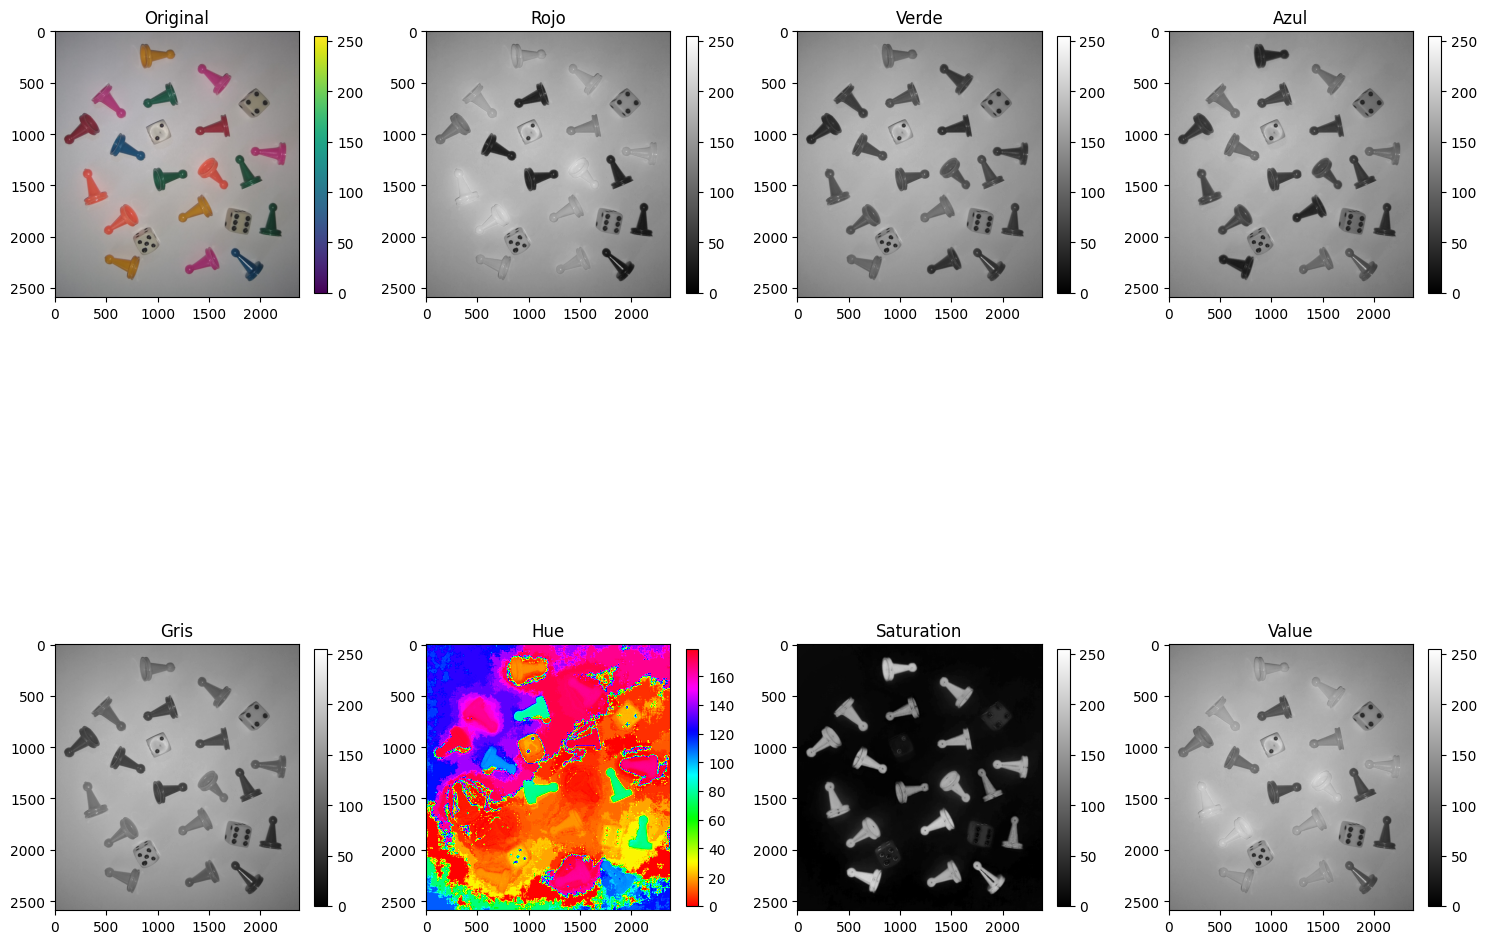

In [26]:
# Imagen comparativa
filas, columnas = 2, 4
fig, axs = plt.subplots(filas, columnas, figsize=(15, 15))

titulos = ['Original', 'Rojo', 'Verde', 'Azul', 'Gris', 'Hue', 'Saturation', 'Value']
imagenes = [Img[:,:,[2,1,0]], Red, Green, Blue, Gray, Hue, Saturation, Value]
vmin_values = [ 0, 0, 0, 0, 0, 0, 0, 0]
vmax_values = [255, 255, 255, 255, 255, 179, 255, 255]
cmaps = [None,'gray','gray','gray','gray','hsv','gray','gray']

for i, (imagen, vmin, vmax, titulo, cmap) in enumerate(zip(imagenes, vmin_values, vmax_values, titulos, cmaps)):
    ax = axs[i // columnas, i % columnas]  # Calcular la posición de la subtrama
    im = ax.imshow(imagen.astype('uint8'), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(titulo)
    fig.colorbar(im, ax=ax, shrink=0.3)  # Ajustar el tamaño del colorbar para que coincida con el tamaño de la subtrama

plt.tight_layout()
plt.show()

Resultado de segmentación


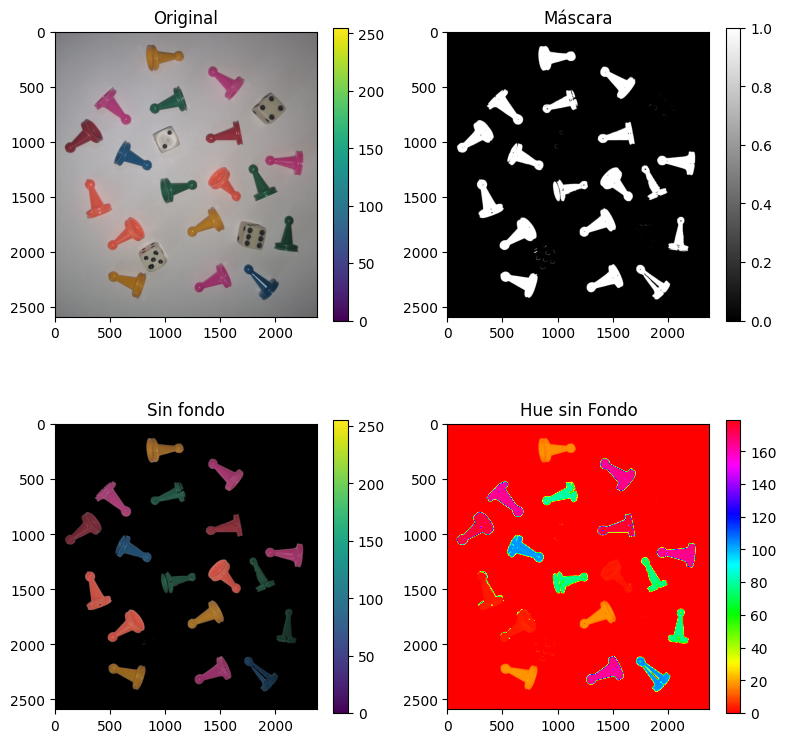

In [ ]:
#Segmentación de fondo
[fi, ci, chi] = Img.shape

##1. Debo crear una imagen con pixeles en ceros
MascaraNoFondo = np.zeros((fi,ci))

##2. Del análisis de la imagen comparativa, concluyo que el fondo se compone de los pixeles con una saturación < 80
##   Entonces para tener la imagen sin fondo necesito saturation < 90, este es mi "Máscara/Filtro"
MascaraNoFondo = Saturation > 90
ImgSinFondo = np.zeros((fi,ci,chi))
HueSinFondo = np.zeros((fi,ci,0))
ImgSinFondo[:,:,0] = Img[:,:,0] * MascaraNoFondo
ImgSinFondo[:,:,1] = Img[:,:,1] * MascaraNoFondo
ImgSinFondo[:,:,2] = Img[:,:,2] * MascaraNoFondo
HueSinFondo = Hue * MascaraNoFondo

##3. Imprimo el resultado de la segmentación
print('Resultado de segmentación')
filas, columnas = 2, 2
fig, axs = plt.subplots(filas, columnas, figsize=(8, 8))

titulos = ['Original', 'Máscara', 'Sin fondo', 'Hue sin Fondo']
imagenes = [Img[:,:,[2,1,0]], MascaraNoFondo, ImgSinFondo[:,:,[2,1,0]], HueSinFondo]
vmin_values = [ 0, 0, 0, 0]
vmax_values = [255, 1, 255, 179,]
cmaps = [None,'gray', None,'hsv']

for i, (imagen, vmin, vmax, titulo, cmap) in enumerate(zip(imagenes, vmin_values, vmax_values, titulos, cmaps)):
    ax = axs[i // columnas, i % columnas]  # Calcular la posición de la subtrama
    im = ax.imshow(imagen.astype('uint8'), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(titulo)
    fig.colorbar(im, ax=ax, shrink=0.8)  # Ajustar el tamaño del colorbar para que coincida con el tamaño de la subtrama

plt.tight_layout()
plt.show()


In [ ]:
#Número de contornos en la imagen
(contornos,_) =cv2.findContours(MascaraNoFondo.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cv2.RETR_EXTERNAL, con esto solo se toman los contornos más externos,
#      ej: una oreo de huequito es un ejemplo, para reconocerla necesitamos el contorno más externo
# cv2.CHAIN_APPROX_SIMPLE, con esto el contorno se aproxima a una región geomeétrica simple,
#      ej: para reconocer una forma cuadrada solo se necesitan 4 puntos
print('Usted tiene '+ str(len(contornos))+' contornos en la escena.')

Usted tiene 437 contornos en la escena.


**Operaciones morfológicas** Limpieza / refinamieno de imágenes

Resultado de segmentación


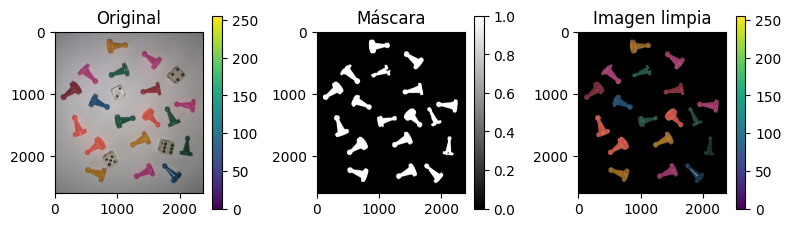

In [31]:
#Limpieza
#Aplicando operaciones morfológicas de apertura sobre la Máscara No fondo

#Llenado de contornos con tamaño menos a 20x20
Filled = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))

#Este es para cerrar
Opened = cv2.morphologyEx(MascaraNoFondo.astype('uint8'), cv2.MORPH_OPEN, Filled)
Closed = cv2.morphologyEx(Opened.astype('uint8'), cv2.MORPH_CLOSE, Filled)

ImgLimpia = np.zeros((fi,ci,chi))
ImgLimpia[:,:,2] = Img[:,:,2] * Closed
ImgLimpia[:,:,1] = Img[:,:,1] * Closed
ImgLimpia[:,:,0] = Img[:,:,0] * Closed

##3. Imprimo el resultado de la segmentación
print('Resultado de segmentación')
filas, columnas = 1, 3
fig, axs = plt.subplots(filas, columnas, figsize=(8, 8))

titulos = ['Original', 'Máscara', 'Imagen limpia']
imagenes = [Img[:,:,[2,1,0]], Closed, ImgLimpia[:,:,[2,1,0]]]
vmin_values = [ 0, 0, 0]
vmax_values = [255, 1, 255]
cmaps = [None,'gray', None]

# Asegurar que axs sea bidimensional
axs = axs.reshape(filas, columnas)

for i, (imagen, vmin, vmax, titulo, cmap) in enumerate(zip(imagenes, vmin_values, vmax_values, titulos, cmaps)):
    ax = axs[i // columnas, i % columnas]  # Calcular la posición de la subtrama
    im = ax.imshow(imagen.astype('uint8'), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(titulo)
    fig.colorbar(im, ax=ax, shrink=0.25)  # Ajustar el tamaño del colorbar para que coincida con el tamaño de la subtrama

plt.tight_layout()
plt.show()


In [32]:
#Número de contornos en la imagen
(contornos,_) =cv2.findContours(Closed.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cv2.RETR_EXTERNAL, con esto solo se toman los contornos más externos,
#      ej: una oreo de huequito es un ejemplo, para reconocerla necesitamos el contorno más externo
# cv2.CHAIN_APPROX_SIMPLE, con esto el contorno se aproxima a una región geomeétrica simple,
#      ej: para reconocer una forma cuadrada solo se necesitan 4 puntos
print('Usted tiene '+ str(len(contornos))+' contornos en la escena.')

Usted tiene 18 contornos en la escena.
